In [1]:
import tensorflow as tf
from tensorflow import keras

# Resnet

## Basic Block
For Resnet18, Resnet34

In [21]:
class BasicBlock(keras.layers.Layer):

  def __init__(self, kernels, stride = 1):
    super().__init__() #inherit from superclass keras.layer.Layers, then add more inits

    #-------------| Features |------------#
    self.features = keras.Sequential([
                                keras.layers.Conv2D(kernels, kernel_size=(3,3), strides=stride, padding="same"),
                                keras.layers.BatchNormalization(),
                                keras.layers.ReLU(),
                                keras.layers.Conv2D(kernels, kernel_size=(3,3), strides=1, padding="same"),
                                keras.layers.BatchNormalization()
    ])

    #----------| Skip Connection |---------#
    if stride != 1:
      skip = [
              keras.layers.Conv2D(kernels, (1, 1), strides=1),
              keras.layers.BatchNormalization()
      ]
    else:
      skip = []

    self.skip = keras.Sequential(skip)

    #--------------| Call |----------------#
    def call(self, inputs, training = False):
      residual = self.skip(inputs, training = training)
      x = self.features(inputs, training = training)
      x = tf.nn.relu(keras.layers.add([residual, x]))
      return x

## Bottle Neck Block
For Resnet50, Resnet101, Resnet152

In [22]:
class BottleNeckBlock(keras.layers.Layer):
  def __init__(self):
    super().__init__()

    #-------------| Features |------------#
    self.features = keras.Sequential([
                                keras.layers.Conv2D(kernels, kernel_size = (1,1), strides=1, padding = "same"),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(kernels, kernel_size = (3,3), strides=stride, padding = "same"),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(kernels * 4, kernel_size = (1,1), strides=1, padding = "same"),
                                keras.layers.BatchNormalization(),

    ])

    #----------| Skip Connection |---------#
    self.skip = keras.Sequential([
                            keras.layers.Conv2D(kernels * 4, kernel_size = (1,1), strides=1),
                            keras.layers.BatchNormalization(),
                            
    ])

    #--------------| Call |----------------#
    def call(self, inputs, training = False):
      residual = self.skip(inputs, training = training)
      x = self.features(inputs, training = training)
      x = tf.nn.relu(x + residual)
      return x

## Build Resnet

In [31]:
class ResNet(keras.Model):
  def __init__(self, block, num_blocks, num_classes, input_shape = (32, 32, 3)):
    super().__init__()
    self.conv1 = keras.Sequential([
                             keras.layers.Input(input_shape),
                             keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias = False), #?????????
                             keras.layers.BatchNormalization(),
                             keras.layers.ReLU()
    ])
    self.conv2 = self.make_layer(block, 64, num_blocks[0], 1)
    self.conv3 = self.make_layer(block, 128, num_blocks[1], 2)
    self.conv4 = self.make_layer(block, 256, num_blocks[2], 2)
    self.conv5 = self.make_layer(block, 512, num_blocks[3], 2)
    self.avg_pool = keras.layers.GlobalAveragePooling2D()
    self.full_connect = keras.layers.Dense(num_classes, activation = "softmax")


  def make_layer(self, block, kernels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1) #?????????
    nets = []
    for stride in strides:
      nets.append(block(kernels, stride))
    return keras.Sequential(nets)

  def call():
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.full_connect(x)
    return(x)

## Models

In [24]:
def ResNet18(num_classes):
    return ResNet(block = BasicBlock, num_blocks = [2, 2, 2, 2], num_classes = num_classes)


def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes):
    return ResNet(BottleNeckBlock, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes):
    return ResNet(BottleNeckBlock, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes):
    return ResNet(BottleNeckBlock, [3, 8, 36, 3], num_classes)

In [51]:
model = ResNet18(num_classes = 100)

# Make model straight up

In [41]:
from functools import partial 
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size = 3, strides =1,
                        padding = "SAME", use_bias= False)

class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides = 1, activation = "relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
                        DefaultConv2D(filters, strides=strides),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        DefaultConv2D(filters),
                        keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
                          DefaultConv2D(filters, kernel_size = 1, strides = strides),
                          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z= inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z= layer(skip_Z)
    return self.activation(Z + skip_Z)

In [42]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size = 7, strides = 2,
                        input_shape = [224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "SAME"))
prev_filters= 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides = strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

In [43]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_42 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)      

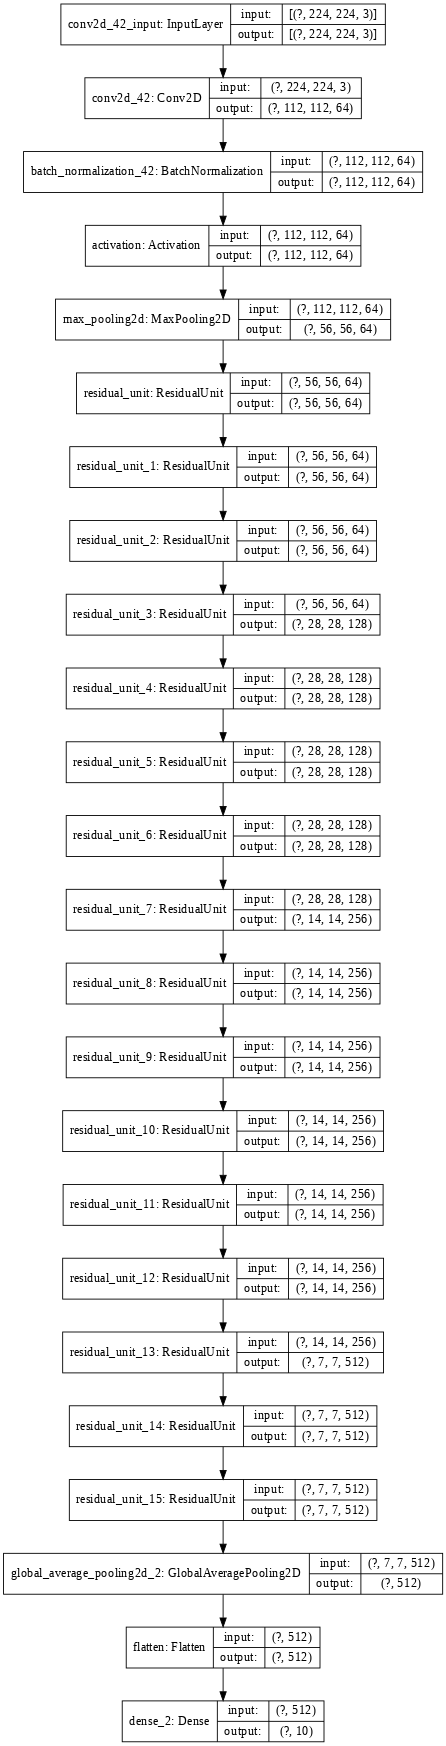

In [44]:
tf.keras.utils.plot_model(model, show_shapes = True, dpi = 64)